# **Image Classification**

<a target="_blank" href="https://github.com/amaciag/CV-Experiments/blob/main/Shampoo_Image_Classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png"/>View source on GitHub</a>

Image classification is the supervised learning process of identifying what an image represents.
This tutorial shows how to use transfer learning and data augmentation approaches to train an image classifier on a smaller dataset. 

## **Import appropriate modules for this tutorial**

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from IPython.display import Javascript
from google.colab import drive

def resize_output_cell(height=300):
  display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: %i})''' %height))

get_ipython().events.register('pre_run_cell', resize_output_cell)
print('Tensoflow Version: ', tf.__version__)

Tensoflow Version:  2.8.0


## **Get shampoo image data**

In [2]:
# Get shampoo image data

!sudo apt-get install subversion
!svn export https://github.com/amaciag/CV-Experiments/trunk/data --force
!unzip -o data/shampoos.zip -d data

<IPython.core.display.Javascript object>

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 67 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubun

## **Create resuable functions**

In [3]:
# Augment image data by adding some random rotaion
data_augment = tf.keras.Sequential(
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05, fill_mode='nearest')
)

# Normalize RGB values to the range from 0 to 1 
def normalize(images, labels):
  
  images = images/255.0
  return images, labels

# Create a training or validation dataset
# Get class names
def prepare_dataset(filepath, mode):

  dataset = tf.keras.utils.image_dataset_from_directory(filepath,
                                         validation_split=0.15,
                                         subset=mode,
                                         seed=123,
                                         image_size=(228, 228),
                                         batch_size=3)
  
  class_names = dataset.class_names

  dataset = dataset.map(normalize, num_parallel_calls = tf.data.AUTOTUNE)
  
  if mode == 'training':
    dataset = dataset.map(lambda images, labels: (data_augment(images), labels), num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.repeat(None)

  else:
    dataset = dataset.repeat(1)

  return class_names, dataset.prefetch(buffer_size = tf.data.AUTOTUNE) 

# Build a customized model using transfer learning
# Add a couple of extra layers on top of the base model
# Parameters in these new layers will be trained to map extracted features to classification results
def build_model(base_model):
  
  inputs = tf.keras.Input(shape=(228, 228, 3))
  x = base_model(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
  
  final_model = tf.keras.Model(inputs, outputs)
  final_model.compile(optimizer='adam', 
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])
  return final_model

# Plot images and optionally compare them with predictions
def plot_images(ds, model=None):
    
    fig, ax = plt.subplots(len(ds), 3, figsize=(10,10))
    count = 0
    ax = ax.flatten()
    for images, labels in ds:
        # print(count)
        if model is not None:
            predictions = model.predict(images)
            titles = np.argmax(predictions, axis=1)
            colors = np.where(titles==labels.numpy().flatten(), 'blue', 'red')
        else:
            titles = labels.numpy().flatten()
            colors = np.full(3, 'blue')

        for i in range(images.shape[0]):
            ax[count].imshow(images[i])
            ax[count].set_title(class_names[titles[i]], color=colors[i])
            ax[count].xaxis.set_visible(False)
            ax[count].yaxis.set_visible(False)
            count += 1
    plt.show()
        
# Plot model training perfomance
def visualize_training(history):
  
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax = ax.flatten()
  epochs = history.epoch

  ax[0].plot(epochs, history.history['loss'], label='training loss')
  ax[0].plot(epochs, history.history['val_loss'], label='validation loss')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('loss')
  ax[0].legend()

  ax[1].plot(epochs, history.history['accuracy'], label='training accuracy')
  ax[1].plot(epochs, history.history['val_accuracy'], label='validation accuracy')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()

  plt.legend()
  plt.show()

<IPython.core.display.Javascript object>

## **Prepare datasets and plot sample image data**

In [4]:
class_names, train_ds = prepare_dataset('data/shampoos', 'training')
_, eval_ds = prepare_dataset('data/shampoos', 'validation')

<IPython.core.display.Javascript object>

Found 60 files belonging to 3 classes.
Using 51 files for training.
Found 60 files belonging to 3 classes.
Using 9 files for validation.


In [5]:
# Print some labels

for images, labels in train_ds.take(9):
  print(labels)

<IPython.core.display.Javascript object>

tf.Tensor([2 0 0], shape=(3,), dtype=int32)
tf.Tensor([0 0 2], shape=(3,), dtype=int32)
tf.Tensor([0 2 2], shape=(3,), dtype=int32)
tf.Tensor([1 1 2], shape=(3,), dtype=int32)
tf.Tensor([1 1 2], shape=(3,), dtype=int32)
tf.Tensor([1 1 0], shape=(3,), dtype=int32)
tf.Tensor([1 1 0], shape=(3,), dtype=int32)
tf.Tensor([1 2 2], shape=(3,), dtype=int32)
tf.Tensor([0 1 2], shape=(3,), dtype=int32)


<IPython.core.display.Javascript object>

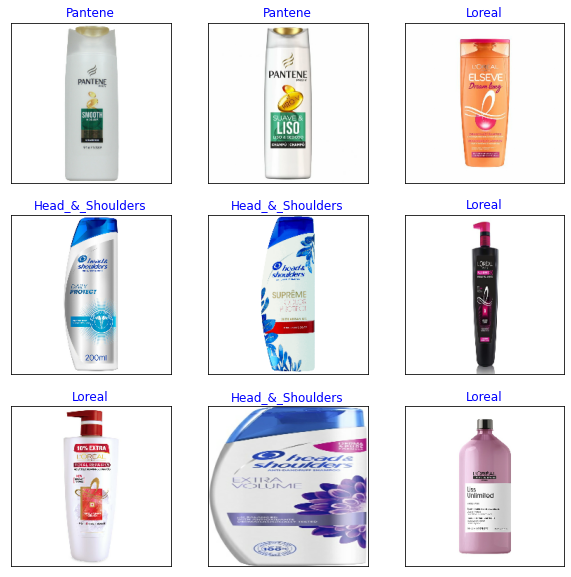

In [6]:
# Plot some images

plot_images(eval_ds)

<IPython.core.display.Javascript object>

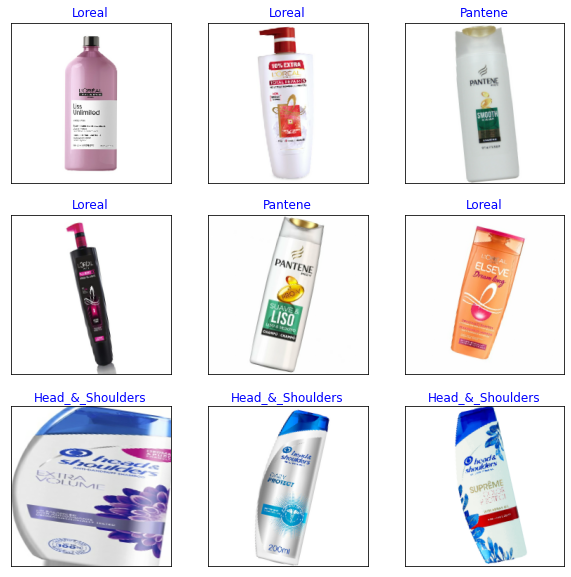

In [7]:
# Plot augmented images

augmented = eval_ds.map(lambda images, labels: (data_augment(images), labels))
plot_images(augmented)


## **Build a transfer learning model**

A pre-trained model called Xception is loaded for this tutorial. It is a convolutional nn that contains roughly 71 layers. Since the pre-trained model has been already trained, its weights can be utilized to transform raw input images.

In [8]:
# Load the Xception pre-trained model without the last layer
# This model will be used as a feature extractor
# Since the feature extractor has been trained, freeze the trainable parameters so that they will not be updated during training

xception_model = getattr(tf.keras.applications, 'Xception')(include_top=False, input_shape=(228, 228, 3))
xception_model.trainable = False
xception_model.summary()

<IPython.core.display.Javascript object>

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 228, 228, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 113, 113, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 113, 113, 32  128        ['block1_conv1[0][0]']           
 ation)                   

<IPython.core.display.Javascript object>

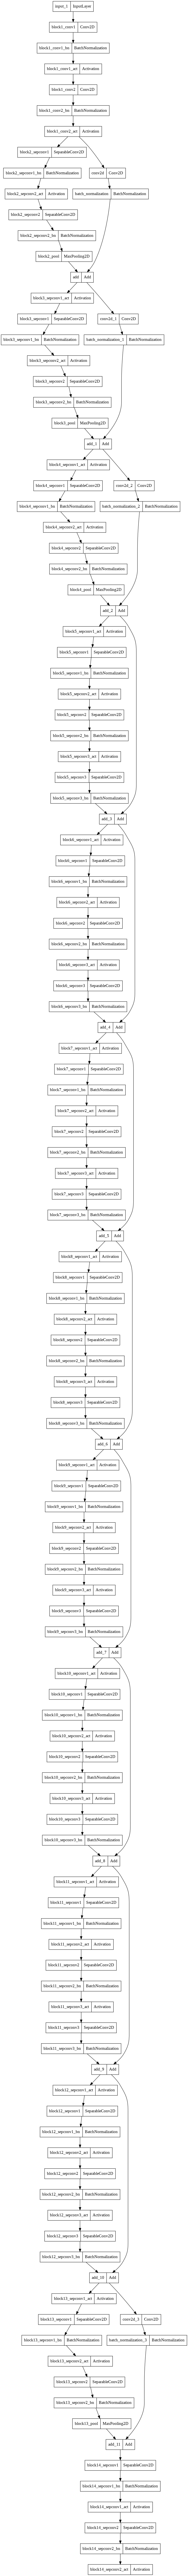

In [9]:
# Visualize xception_model

tf.keras.utils.plot_model(xception_model)

In [10]:
# Build a customized model
# Xception is used as a feature extractor

func_model = build_model(xception_model)
func_model.summary()

<IPython.core.display.Javascript object>

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 228, 228, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 20,867,627
Trainable params: 6,147
Non-trainable params: 20,861,480
_____________________________________________

<IPython.core.display.Javascript object>

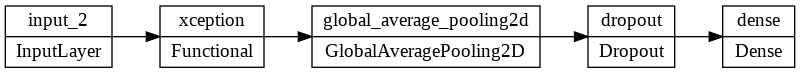

In [11]:
# Visualize func_model

tf.keras.utils.plot_model(func_model, rankdir='LR')

## **Train the model**

In [12]:
# Set a small number of training iterations

num_examples = 51
epochs = 15
steps_per_epoch = np.ceil(5*num_examples/(3*epochs))

<IPython.core.display.Javascript object>

In [13]:
# Instantiate EarlyStopping to stop training if no progress is seen
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]

# Train the customized model
history = func_model.fit(train_ds, epochs=epochs, 
                         steps_per_epoch=steps_per_epoch, 
                         validation_data=eval_ds,
                         callbacks=callbacks)

<IPython.core.display.Javascript object>

Epoch 1/15
6/6 [==============================] - 16s 243ms/step - loss: 1.0079 - accuracy: 0.5000 - val_loss: 1.1750 - val_accuracy: 0.5556
Epoch 2/15
6/6 [==============================] - 0s 56ms/step - loss: 1.2698 - accuracy: 0.4444 - val_loss: 0.9722 - val_accuracy: 0.4444
Epoch 3/15
6/6 [==============================] - 1s 132ms/step - loss: 0.7870 - accuracy: 0.6667 - val_loss: 0.7613 - val_accuracy: 0.8889
Epoch 4/15
6/6 [==============================] - 0s 60ms/step - loss: 0.6950 - accuracy: 0.7778 - val_loss: 0.7151 - val_accuracy: 0.7778
Epoch 5/15
6/6 [==============================] - 0s 57ms/step - loss: 0.6177 - accuracy: 0.8889 - val_loss: 0.7296 - val_accuracy: 0.6667
Epoch 6/15
6/6 [==============================] - 1s 134ms/step - loss: 0.4984 - accuracy: 0.9444 - val_loss: 0.6697 - val_accuracy: 0.7778
Epoch 7/15
6/6 [==============================] - 0s 52ms/step - loss: 0.4317 - accuracy: 0.9444 - val_loss: 0.7046 - val_accuracy: 0.6667
Epoch 8/15
6/6 [=======

# **Evaluate the model and get predictions**

<IPython.core.display.Javascript object>

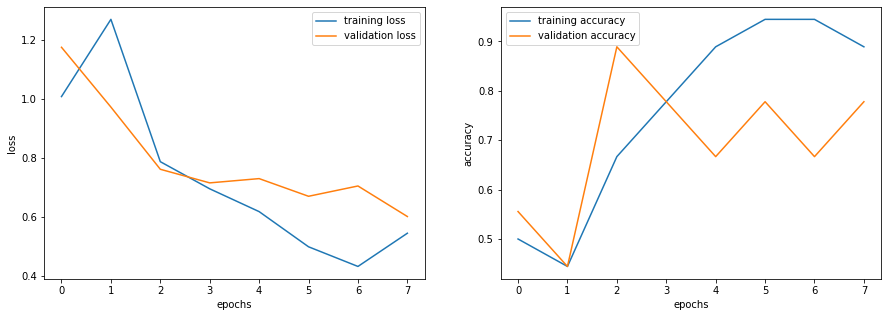

In [14]:
# Plot model perfomance

visualize_training(history)

In [15]:
# Print metrics

loss, accuracy = func_model.evaluate(eval_ds)
print(f'Loss: {loss}\nAccuracy: {accuracy}')

<IPython.core.display.Javascript object>

3/3 [==============================] - 0s 32ms/step - loss: 0.6010 - accuracy: 0.7778
Loss: 0.6010262370109558
Accuracy: 0.7777777910232544


<IPython.core.display.Javascript object>

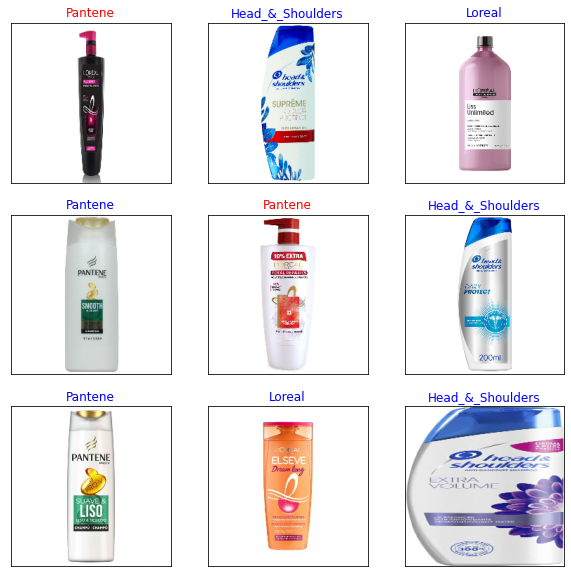

In [16]:
# Get and check predictions

plot_images(eval_ds, func_model)

## **Exercise**

All the exercise steps below can be done by reusing the above code cells starting from **Build a transfer learning model**.

<IPython.core.display.Javascript object>

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 228, 228, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_286 (Conv2D)            (None, 113, 113, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_286 (Batch  (None, 113, 113, 32  96         ['conv2d_286[0][0]']             
 Normalization)                 )                                                      

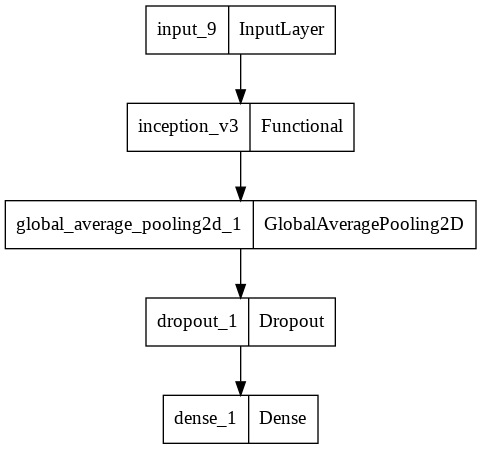

In [25]:
# Create your image classification model
pretrained_models = ['InceptionV3', 'Resnet50', 'VGG16', 'VGG19', 'Xception']

# 1. Pick a model from pretrained_models and create the model instance
inception_model = getattr(tf.keras.applications, 'InceptionV3')(include_top=False, input_shape=(228, 228, 3))

# 2. Freeze your base model's trainable parameters 
inception_model.trainable = False
inception_model.summary()

# 3. Build your final customized model
func_model = build_model(inception_model)

# 4. Plot your model or display its summary
tf.keras.utils.plot_model(func_model)

In [26]:
# Train your final model

# Instantiate EarlyStopping to stop training if no progress is seen
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]

# Train the customized model
history = func_model.fit(train_ds, epochs=epochs, 
                         steps_per_epoch=steps_per_epoch, 
                         validation_data=eval_ds,
                         callbacks=callbacks)

<IPython.core.display.Javascript object>

Epoch 1/15
6/6 [==============================] - 7s 308ms/step - loss: 1.3699 - accuracy: 0.2778 - val_loss: 0.9238 - val_accuracy: 0.5556
Epoch 2/15
6/6 [==============================] - 0s 53ms/step - loss: 0.7958 - accuracy: 0.6667 - val_loss: 0.7584 - val_accuracy: 0.5556
Epoch 3/15
6/6 [==============================] - 1s 121ms/step - loss: 0.7133 - accuracy: 0.7778 - val_loss: 0.6291 - val_accuracy: 0.7778
Epoch 4/15
6/6 [==============================] - 0s 55ms/step - loss: 0.4173 - accuracy: 0.8333 - val_loss: 0.8561 - val_accuracy: 0.8889
Epoch 5/15
6/6 [==============================] - 0s 54ms/step - loss: 0.6204 - accuracy: 0.7778 - val_loss: 0.6678 - val_accuracy: 0.7778
Epoch 6/15
6/6 [==============================] - 1s 123ms/step - loss: 0.3089 - accuracy: 0.9444 - val_loss: 0.6340 - val_accuracy: 0.6667
Epoch 7/15
6/6 [==============================] - 0s 58ms/step - loss: 0.3941 - accuracy: 0.7778 - val_loss: 0.6665 - val_accuracy: 0.7778
Epoch 8/15
6/6 [========

<IPython.core.display.Javascript object>

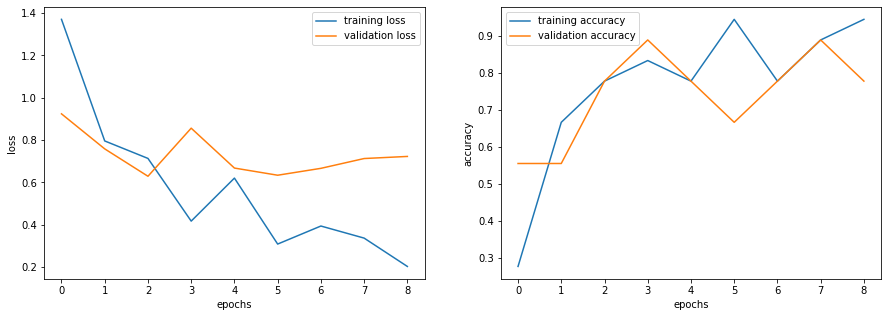

In [27]:
# Visualize your model training performance
visualize_training(history)

<IPython.core.display.Javascript object>

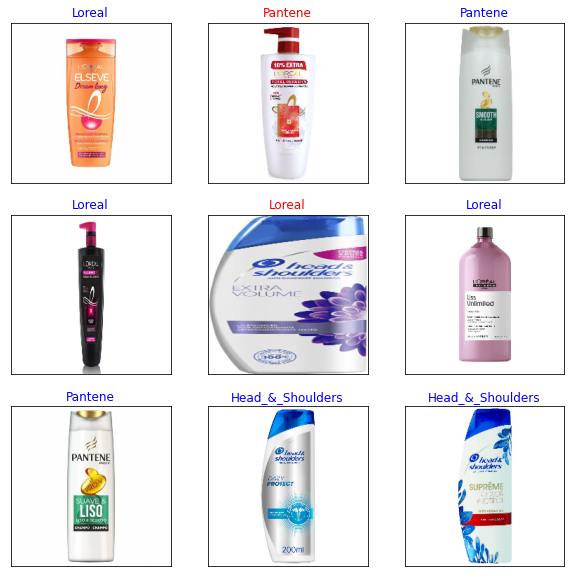

In [28]:
# Get and check your model predictions
plot_images(eval_ds, func_model)